# Kalman filters Italy

### Table of contents
1. [Data](#Data)
2. [Model with the vector c fixed as [0, 1]](#Model-with-the-vector-c-fixed-as-[0,-1])
3. [Model with the vector c as a random variable with prior](#Model-with-the-vector-c-as-a-random-variable-with-prior)
4. [Model without input (2 hidden variables)](#Model-without-input)

In [1]:
import sys
from os.path import pardir, join

import pandas as pd
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt


import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax
np.random.seed(42)

In [3]:
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
ROOT = pardir
DATA = join(ROOT, "data", "processed")

## Data

The data from Spain has 57 unduplicated dates.

In [6]:
data = pd.read_csv(join(DATA, 'data_spain_sixcol.csv')).values
X = data[:, 2:].astype(np.float_)
y = data[:,1].astype(np.float_)

n_train = 45
n_test = len(y)-n_train

idx_train = [*range(0,n_train)]
idx_test = [*range(n_train, len(y))]

y_train = y[idx_train]
y_test = y[idx_test]

## Model with the vector c fixed as [0, 1]

In [7]:
sys.path.append(join(ROOT, "src", "models"))
sys.path.append(join(ROOT, "src", "visualization"))

from kf_input import model_wo_c, model_w_c
from train import train_kf
from visualize import get_samples, plot_samples, plot_forecast

In [7]:
mcmc = train_kf(model_wo_c, y_train, n_train, n_test, num_samples=12000, num_warmup=4000, x=X)

sample: 100%|██████████| 16000/16000 [05:55<00:00, 45.05it/s, 511 steps of size 4.66e-03. acc. prob=0.92]  


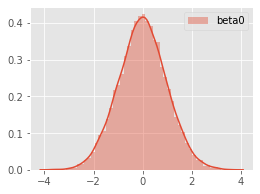

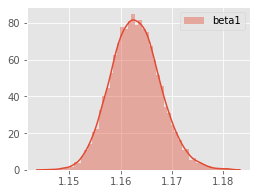

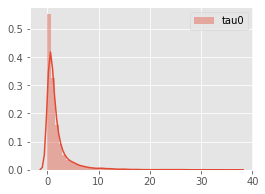

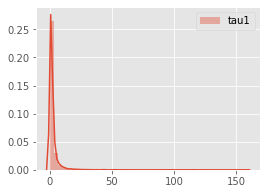

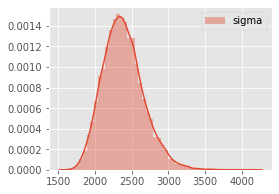

In [8]:
hmc_samples = get_samples(mcmc)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

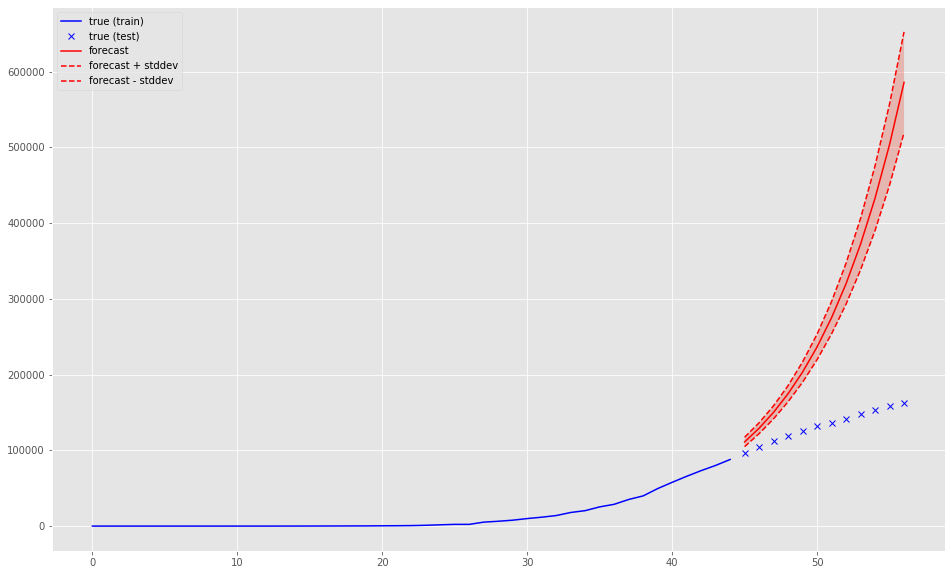

In [9]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

## Model with the vector c as a random variable with prior

In [11]:
mcmc2 = train_kf(model_w_c, y_train, n_train, n_test, num_samples=12000, num_warmup=4000, x=X)

sample: 100%|██████████| 16000/16000 [07:27<00:00, 35.77it/s, 1023 steps of size 1.37e-03. acc. prob=0.91]


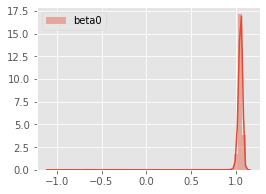

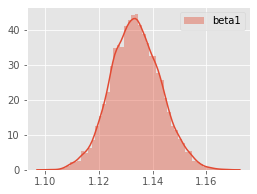

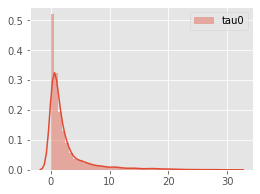

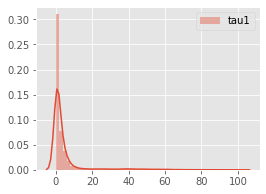

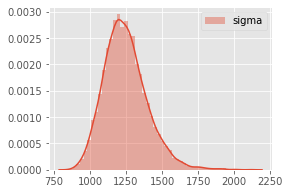

In [12]:
hmc_samples = get_samples(mcmc2)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

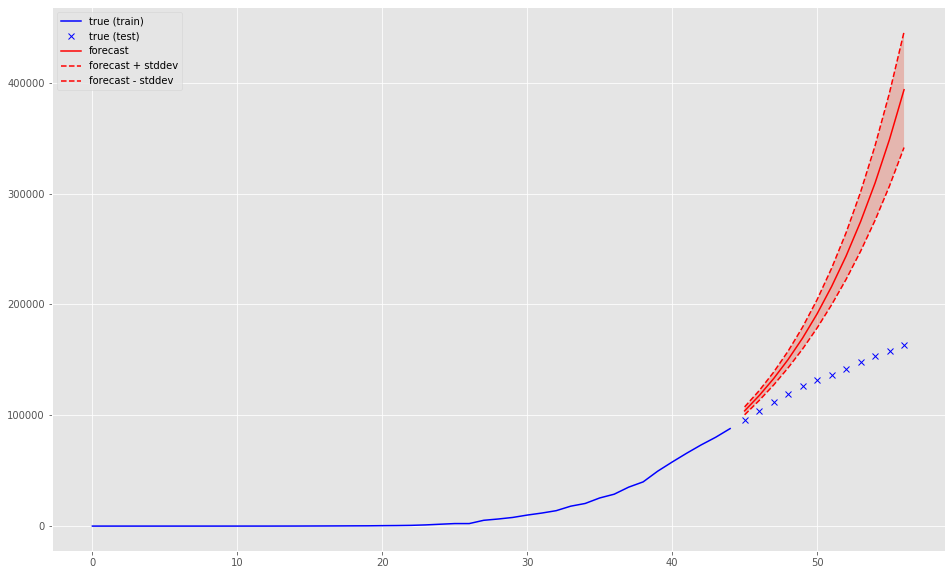

In [13]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

## Model without input
Two hidden variables.

In [7]:
from kf import twoh_c_kf

In [8]:
mcmc3 = train_kf(twoh_c_kf, y_train, n_train, n_test, num_samples=12000, num_warmup=4000)

sample: 100%|██████████| 16000/16000 [01:28<00:00, 180.18it/s, 63 steps of size 4.64e-02. acc. prob=0.82]  


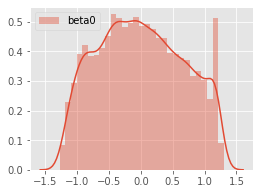

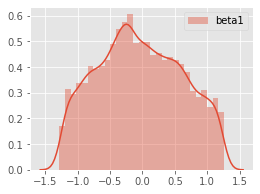

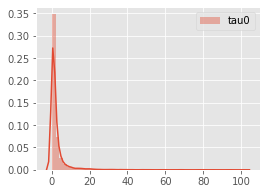

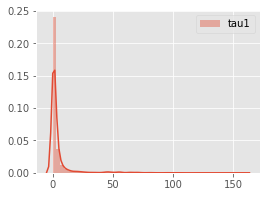

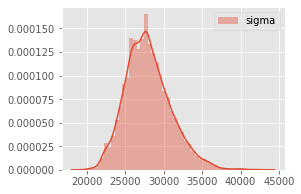

In [9]:
hmc_samples = get_samples(mcmc3)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

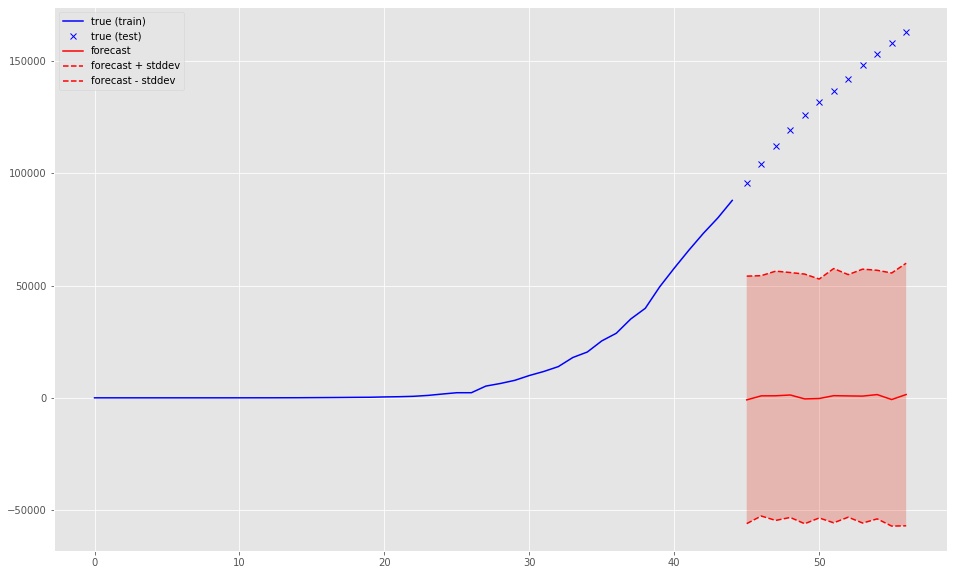

In [10]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

## Model without input
One hidden variable.

In [7]:
from kf import singlevariate_kf

In [8]:
mcmc4 = train_kf(singlevariate_kf, y_train.astype("int"), n_train, n_test, num_samples=12000, num_warmup=4000)

sample: 100%|██████████| 16000/16000 [00:45<00:00, 349.74it/s, 63 steps of size 4.95e-02. acc. prob=0.93]  


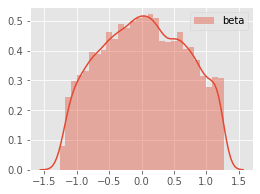

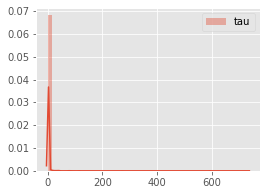

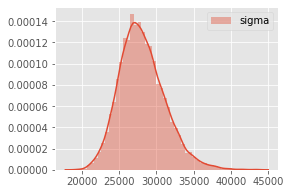

In [9]:
hmc_samples = get_samples(mcmc4)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

This model is (currently) working with one less forecast that it should

In [10]:
y_hat = hmc_samples["y_pred"].mean(axis=0)
y_std = hmc_samples["y_pred"].std(axis=0)
y_pred_025 = y_hat - 1.96 * y_std
y_pred_975 = y_hat + 1.96 * y_std

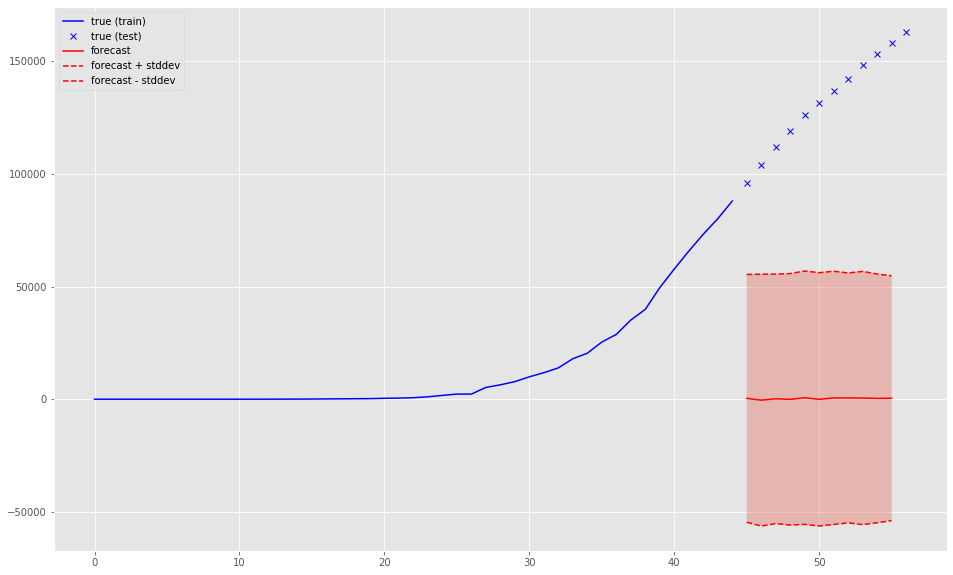

In [11]:
plt.plot(idx_train, y_train, "b-")
plt.plot(idx_test, y_test, "bx")
plt.plot(idx_test[:-1], y_hat, "r-")
plt.plot(idx_test[:-1], y_pred_025, "r--")
plt.plot(idx_test[:-1], y_pred_975, "r--")
plt.fill_between(idx_test[:-1], y_pred_025, y_pred_975, alpha=0.3)
plt.legend(
    [
        "true (train)",
        "true (test)",
        "forecast",
        "forecast + stddev",
        "forecast - stddev",
    ]
)
plt.show()

## Model without input
Two hidden variables, two y outputs.
First, we need to extract the death cases for the dates on the mobility data. We will use the previously processed dataset that already includes the `Confirmed` cases.

In [8]:
data = pd.read_csv(join(DATA, 'data_spain_sixcol.csv'))

In [9]:
data_covid19=pd.read_csv(
    "https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv",
    parse_dates=['Date']
)
covid19 = data_covid19[data_covid19['Country'] == 'Spain'].loc[:, ["Date", "Deaths"]]

In [10]:
covid19["Date"] = pd.to_datetime(covid19["Date"])
data["Date"] = pd.to_datetime(data["Date"])

In [11]:
y_train_x2 = data.merge(covid19, on="Date").loc[:, ["Confirmed", "Deaths"]].to_numpy()[:45,:]

In [12]:
from kf import multivariate_kf

In [13]:
mcmc6 = train_kf(multivariate_kf, y_train_x2.astype("int"), n_train, n_test, num_samples=12000, num_warmup=4000)

sample: 100%|██████████| 16000/16000 [06:57<00:00, 38.28it/s, 1023 steps of size 2.79e-04. acc. prob=0.92] 


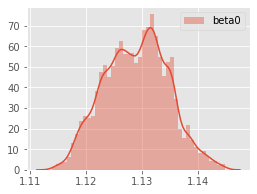

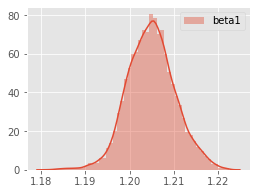

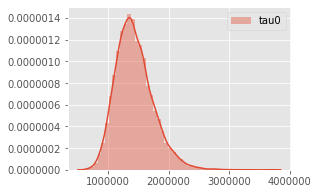

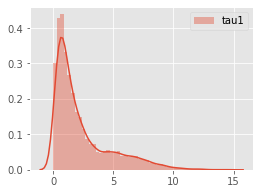

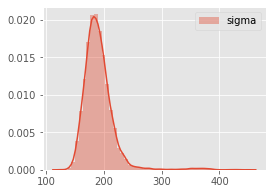

In [15]:
hmc_samples = get_samples(mcmc6)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

In [16]:
q = hmc_samples["y_pred1"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 1.96*q_std
y_pred_975 = q_mean + 1.96*q_std
y_pred_mean = q_mean
q2 = hmc_samples["y_pred2"]
q_mean2 = q2.mean(axis=0).reshape(-1,)
q_std2 = q2.std(axis=0).reshape(-1,)
y_pred_025_2 = q_mean2 - 1.96*q_std
y_pred_975_2 = q_mean2 + 1.96*q_std
y_pred_mean2 = q_mean2
T = 45
T_forecast=12

In [17]:
train = y_train_x2.astype("int")
valid = data.merge(covid19, on="Date").loc[:, ["Confirmed", "Deaths"]].to_numpy()[45:, :]

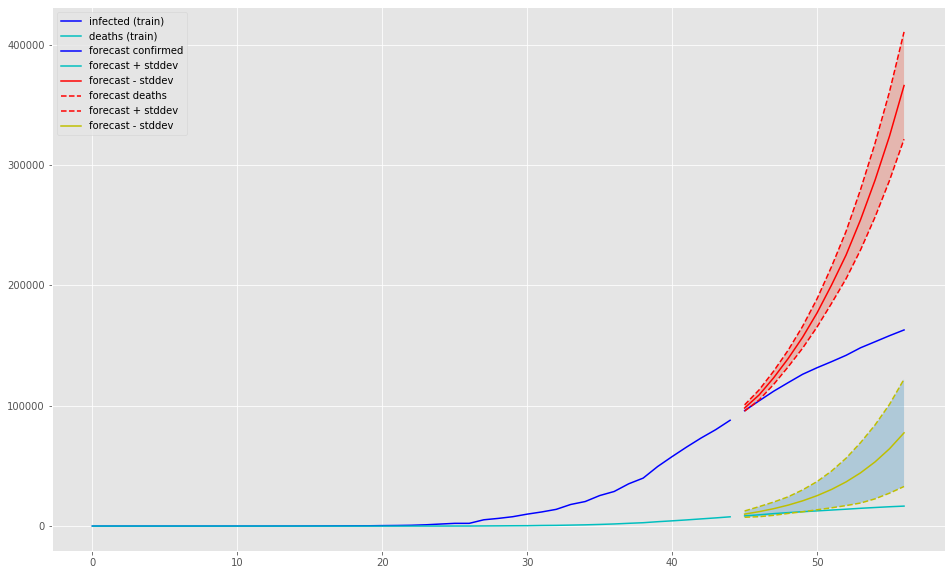

In [19]:
plt.plot(range(T), train[:,0], "b-")
plt.plot(range(T), train[:,1], "c-")
plt.plot(range(T, T+T_forecast), valid[:,0], "b-")
plt.plot(range(T, T+T_forecast), valid[:,1], "c-")
plt.plot(range(T, T+T_forecast), y_pred_mean, "r-")
plt.plot(range(T, T+T_forecast), y_pred_025, "r--")
plt.plot(range(T, T+T_forecast), y_pred_975, "r--")
plt.fill_between(range(T, T+T_forecast), y_pred_025, y_pred_975, alpha=0.3)
plt.plot(range(T, T+T_forecast), y_pred_mean2, "y-")
plt.plot(range(T, T+T_forecast), y_pred_025_2, "y--")
plt.plot(range(T, T+T_forecast), y_pred_975_2, "y--")
plt.fill_between(range(T, T+T_forecast), y_pred_025_2, y_pred_975_2, alpha=0.3)
plt.legend([
    "infected (train)","deaths (train)", "forecast confirmed", "forecast + stddev",
    "forecast - stddev","forecast deaths","forecast + stddev","forecast - stddev"
])
plt.show()